In [31]:
from tools.fgd_util import EmbeddingSpaceEvaluator, convert_dir_vec_to_pose, convert_pose_seq_to_dir_vec, rotation_matrix
from tools.takekuchi_dataset_tool.rot_to_pos import rot2pos
from models.wgan.wgan import ConditionalWGAN

import numpy as np
import torch as th
import matplotlib.pyplot as plt

import pickle

In [2]:
import seaborn as sns
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
sns.set()

lines = [
        [0, 1], [1, 2], [2, 3], [3, 4], [4, 5],
        [3, 6], [6, 7], [7, 8],
        [3, 9], [9, 10], [10, 11]
    ]

def plot_position_3D(motion, path):

    print(f'Plotting with length {motion.shape[0]}')
    
    def update_graph(num):
        x, y, z = motion[num][::3], motion[num][1::3], motion[num][2::3]
        graph._offsets3d = (x, y, z)
        title.set_text('3D Test, step={}'.format(num))

        for g_l, l in zip(graph_lines, lines):
            g_l[0].set_data(x[l], y[l])
            g_l[0].set_3d_properties(z[l])
        
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    title = ax.set_title('3D Test')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    graph = ax.scatter([], [], [], c='b', s=5, alpha=1)
    graph_lines = [ax.plot([], [], [], c='b') for i, _ in enumerate(lines)]

    ax.view_init(0, 45)
    ax.set_ylim(-50, 50)
    ax.set_zlim(0, 100)
    ax.set_xlim(-50, 50)

    anim = FuncAnimation(fig, update_graph, range(motion.shape[0]), interval=50)
    anim.save(path)

    plt.close()


In [9]:
evaluator = EmbeddingSpaceEvaluator(embed_net_path='tools/fgd_chkpt/train_h36m_gesture_autoencoder_gesture_autoencoder_checkpoint_best.bin')

In [10]:
evaluator.push_samples(None, None, poses, poses)

In [11]:
evaluator.get_scores()

(-5.681649705796913e-19, 0.0)

In [24]:
with open('data/takekuchi/processed/mfcc_prosody_text/X_dev.p', 'rb') as f:
    dev_input = pickle.load(f)
with open('data/takekuchi/processed/mfcc_prosody_text/Y_dev.p', 'rb') as f:
    dev_output = pickle.load(f)
with open('data/takekuchi/processed/mfcc_prosody_text/Y_train.p', 'rb') as f:
    train_output = pickle.load(f)

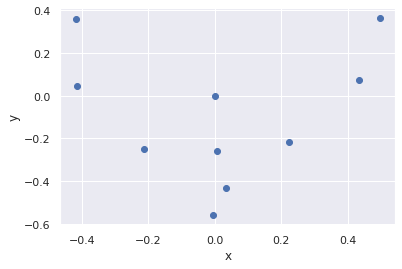

In [8]:
rot = dev_output[0]

padding = np.zeros((rot.shape[0], 3))
rot_padded = np.concatenate([padding, rot], axis=-1)
pos = rot2pos(rot_padded)

# remove hips
pos = pos[:, 6:]

pos = pos.reshape(-1, 10, 3)

# take pos -> h36m pose
pos = convert_dir_vec_to_pose(convert_pose_seq_to_dir_vec(pos))

# rotate z by 180, pos in [z, x, y]
mat = rotation_matrix([1, 0, 0], np.deg2rad(180))
pos = np.matmul(pos, mat)

pos = pos.reshape(-1, 30)

# Check if x and y is correct, with trimodal example
plt.scatter(pos[0][::3], pos[0][1::3])
plt.xlabel('x')
plt.ylabel('y')

# Check if x and z is correct, with trimodal example
# plt.scatter(pos[0][::3], pos[0][2::3])
# plt.xlabel('x')
# plt.ylabel('z')

plt.show()

In [18]:
def convert_takekuchi_pos36_to_trimodal_fgd27(pos):
    assert pos.shape[1] == 36, "pos must be 36 dim."

    # remove hips
    pos = pos[:, 6:]

    pos = pos.reshape(-1, 10, 3)

    # take pos -> h36m pose
    pos = convert_dir_vec_to_pose(convert_pose_seq_to_dir_vec(pos))

    # rotate z by 180, pos in [z, x, y]
    mat = rotation_matrix([1, 0, 0], np.deg2rad(180))
    pos = np.matmul(pos, mat)

    return convert_pose_seq_to_dir_vec(pos).reshape(-1, 27)

In [25]:
train_dir_vec = [convert_takekuchi_pos36_to_trimodal_fgd27(x) for x in train_output]
mean_dir_vec = np.mean(np.concatenate(train_dir_vec, axis=0), axis=0, keepdims=True)

In [26]:
normalized_dev_dir_vec = [convert_takekuchi_pos36_to_trimodal_fgd27(x)-mean_dir_vec for x in dev_output]

In [ ]:


output_list, _, motion_list, indexs = model.synthesize_batch(data.get_test_dataset())
for output, i in zip(output_list, indexs):
    data.save_unity_result(output.cpu().numpy(), os.path.join(f"{path}/motion_{i}.txt"))